# Generalised Bernoulli map with various number formats

Revisiting BM Boghosian, PV Coveney, and H Wang. *A new pathology in the Simulation of Chaotic Dynamical Systems on Digital Computers*, **Adv. Theory Simul.** 2019, 2, 1900125, DOI: 10.1002/adts.201900125

### Load packages

In [1]:
using PyPlot, FileIO, JLD2
using StochasticRounding, SoftPosit, LogFixPoint16s
using StatsBase, LinearAlgebra, Statistics, RandomNumbers
LogFixPoint16s.set_nfrac(10)   # use the 16-bit logfix format similar to Float16

using BernoulliMap

┌ Warning: LogFixPoint16 was changed to 5 integer and 10 fraction bits.
└ @ LogFixPoint16s /Users/milan/.julia/packages/LogFixPoint16s/TGYbV/src/change_format.jl:25


### Functions
Define the generalised Bernoulli map

$\quad x_{j+1} = f_\beta(x_j) = \beta x_j \mod 1$

with $\beta > 1$.

And the Hofbauer invariant measure (Eq. 1 in Boghosian, Coveney and Wang, 2019)

$\quad h_\beta(x) = C\sum_{j=0}^\infty \beta^{-j} \theta(1_j - x)$

with $C$ a normalization constant, $\theta$ the Heaviside function and $1_j = f_\beta^j(1)$.

In [2]:
# Hofbauer invariant measure h with C=1
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
h(x,β,N=100) = heaviside(1-x) + [β^-j for j in 1:N]'*heaviside.(bernoulli_map(1e0,β,N)[2:end] .- x)

h (generic function with 2 methods)

### Some iterations of the Bernoulli map with β=2

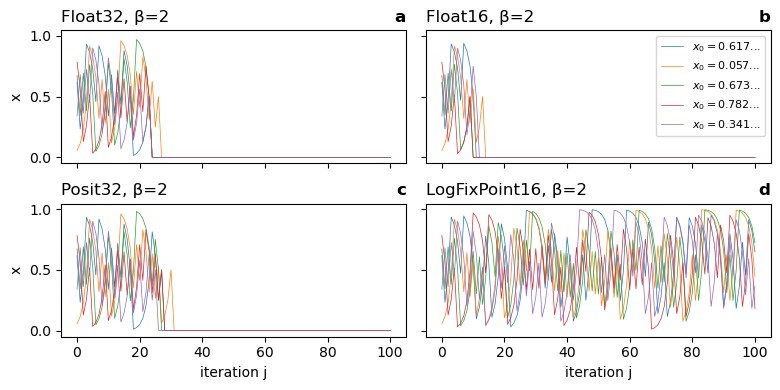

In [3]:
# pick N random start values [0,1)
Nens = 5    # ensemble N
Ns = 100    # iteration N
x0 = rand(Nens)
β = 2

fig,axs = subplots(2,2,sharex=true,sharey=true,figsize=(8,4))

for i in 1:Nens
    axs[1,1].plot(bernoulli_map(Float32(x0[i]),Float32(β),Ns),lw=.5)
    axs[1,2].plot(bernoulli_map(Float16(x0[i]),Float16(β),Ns),lw=.5,label=L"x_0 = "*"$(round(x0[i],digits=3))...")
    axs[2,1].plot(bernoulli_map(Posit32(x0[i]),Posit32(β),Ns),lw=.5)
    axs[2,2].plot(bernoulli_map(LogFixPoint16(x0[i]),LogFixPoint16(β),Ns),lw=.5)
end

axs[1,1].set_title("Float32, β=$β",loc="left")
axs[1,2].set_title("Float16, β=$β",loc="left")
axs[2,1].set_title("Posit32, β=$β",loc="left")
axs[2,2].set_title("LogFixPoint16, β=$β",loc="left")

for (iabc,abc) in enumerate(["a","c","b","d"])
    axs[iabc].set_title(abc,loc="right",fontweight="bold")
end

axs[1,1].set_ylabel("x")
axs[2,1].set_ylabel("x")
axs[2,1].set_xlabel("iteration j")
axs[2,2].set_xlabel("iteration j")

axs[1,2].legend(fontsize=8)

tight_layout()
# savefig("../plots/beta2.png",dpi=200)

**Fig. 1**: The generalised Bernoulli map $f_\beta$ for $\beta=2$ with different number formats. (a) Float32, (b) Float16, (c) Posit32 and (d) LogFixPoint16. The Bernoulli map $f_2$ does not introduce arithmetic rounding errors in (a-c), such that stochastic rounding has no impact. The logfix subtraction in $f_2$ introduces rounding errors in (d) that prevent the stalling at 0 in (a-c).

### Numerical representation of the invariant measures

In [5]:
# Calculate histograms
Nens = 1000              # start from Nens random initial conditions
Nsteps = 20000           # integrate for Nsteps time steps
Nspinup = 5000           # discard Nspinsup time steps

# simulate with formats
formats = [Float64,Float32,Float16]

# each for different β
βs = [3/2,5/4,4/3,6/5]                                                
Nformats = length(formats)
Nβs = length(βs)

# bins
bin_edges = collect(0:2.5e-2:1)
nbins = length(bin_edges)-1

# preallocate all histograms
Histos = fill(0.0,Nformats,Nβs,nbins)

for (iformat,format) in enumerate(formats)
    for (iβ,β) in enumerate(βs)
        X = fill(0.0,Nens,Nsteps)
        for iens in 1:Nens
            f = format(randfloat())
            X[iens,:] = bernoulli_map(f,format(β),Nsteps+Nspinup)[Nspinup+2:end]
        end
        H = fit(Histogram,vec(X),bin_edges).weights
        Histos[iformat,iβ,:] = H / sum(H*(bin_edges[2]-bin_edges[1]))
    end
end     

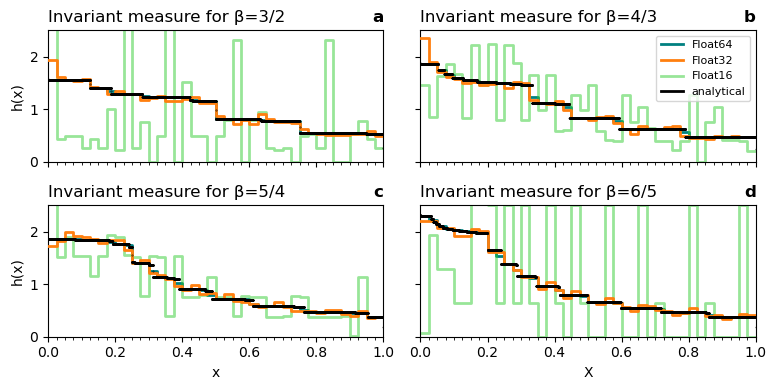

In [6]:
# PLOT
fig,axs = subplots(2,2,sharex=true,figsize=(8,4),sharey=true)

for (iax,ax) in enumerate(axs)
    H = Histos[1,iax,:]
    ax.plot(bin_edges,vcat(H[1],H),"teal",ds="steps-pre",lw=2,label="Float64")
    
    H = Histos[2,iax,:]
    ax.plot(bin_edges,vcat(H[1],H),"C1",ds="steps-pre",lw=2,label="Float32",zorder=9)
    
    H = Histos[3,iax,:]
    ax.plot(bin_edges,vcat(H[1],H),"limegreen",alpha=0.5,ds="steps-pre",lw=2,label="Float16")
    
#     H = Histos[4,iax,:]
#     ax.plot(bin_edges,vcat(H[1],H),ds="steps-pre",lw=2,label="Float32+SR")
end


# Add analytical invariant measures from Hofbauer
x = collect(0:1e-4:1)
for (iβ,β) in enumerate(βs)
    hx = h.(x,β)
    axs[iβ].scatter(x,hx/sum(hx*(x[2]-x[1])),0.1,color="k",zorder=10)
    # only for legend (plot outside xlim,ylim)
    axs[iβ].plot(-x,hx/sum(hx*(x[2]-x[1])),"k",lw=2,label="analytical")
end

for (iβ,β) in enumerate(["3/2","5/4","4/3","6/5"])
    axs[iβ].set_title("Invariant measure for β=$β",loc="left")
end

for (iabc,abc) in enumerate(["a","c","b","d"])
    axs[iabc].set_title(abc,loc="right",fontweight="bold")
end

axs[1,2].legend(loc=1,fontsize=8)

axs[1,1].set_ylabel("h(x)")
axs[2,1].set_ylabel("h(x)")
axs[2,1].set_xlabel("x")
axs[2,2].set_xlabel("X")
axs[1,1].set_xlim(0,1)
axs[1,1].set_ylim(0,2.5)
axs[1,1].set_xticks(bin_edges,minor=true)

tight_layout()
# savefig("../plots/inv_measures.png",dpi=200)

**Fig. 2**: The invariant measures of the generalised Bernoulli map for β = (a) $\frac{3}{2}$, (b) $\frac{4}{3}$, (c) $\frac{5}{4}$ and (d) $\frac{6}{5}$ calculated with different number formats Float16, Float32 and Float64. The invariant measures are obtained from long integrations of the Bernoulli map from many different initial conditions $x_0$ in [0,1). Histograms of $x$ with bin width 0.025 and the analytical invariant measures are normalised.

### Invariant measure bifurcation figure

In [7]:
# ANALYTICAL
x2 = collect(0:5e-3:1)
βs2 = collect(1:1e-3:2)

# bins
bin_edges = collect(0:2.5e-2:1)
bin_mids = bin_edges[1:end-1] + diff(bin_edges)/2
nbins = length(bin_edges)-1

Nens = 100               # start from Nens random initial conditions
Nsteps = 10000           # integrate for Nsteps time steps

# preallocate
nx,nβs = length(x2),length(βs2)
hxβ0 = fill(0.0,nx,nβs)
hxβ = fill(0.0,nbins,nβs)

# Invariant measures directly (for correct normalisation only)
for (iβ,β) in enumerate(βs2)
    hx = h.(x2,β)
    hxβ0[:,iβ] = hx/sum(hx*(x2[2]-x2[1]))
end

# get the analytical distribution from Hofbauer's h(x)
# then sample & calculate a histogram as with the numerical simulations
for (iβ,β) in enumerate(βs2) 
    aw = aweights(hxβ0[:,iβ])
    xsample = sample(x2,aw,Nsteps*Nens)
    
    H = fit(Histogram,xsample,bin_edges).weights
    hxβ[:,iβ] = H / sum(H*(bin_edges[2]-bin_edges[1]))
end

In [114]:
# preallocate all histograms
formats = [Float64,Float32,Posit32,Float32sr,Float16]
Nformats = length(formats)

# bins
bin_edges = collect(0:2.5e-2:1)
nbins = length(bin_edges)-1

Nens = 100                # start from Nens random initial conditions
Nsteps = 10000            # integrate for Nsteps time steps
Nspinup = 5000            # discard Nspinsup time steps
Histos2 = fill(0.0,Nformats,nβs,nbins)

for (iformat,format) in enumerate(formats)
    print("$format,")
    for (iβ,β) in enumerate(βs2)
        X = fill(0.0,Nens,Nsteps)
        for iens in 1:Nens
            f = format(rand())
            X[iens,:] = bernoulli_map(f,format(β),Nsteps+Nspinup)[Nspinup+2:end]
        end
        H = fit(Histogram,vec(X),bin_edges).weights
        Histos2[iformat,iβ,:] = H / sum(H*(bin_edges[2]-bin_edges[1]))
    end
end

In [11]:
# @save "histograms.jld2" Histos2 hxβ formats βs2 bin_edges
@load "histograms.jld2" Histos2 hxβ formats βs2 bin_edges
Nformats = length(formats);

In [12]:
# normalise
hxβn = copy(hxβ)
Histos2n = fill(0.0,Nformats,nbins,nβs)
ββ = fill(0.0,nbins,nβs)

for (iβ,β) in enumerate(βs2)
    ββ[:,iβ] .= β
    m = maximum(hxβ0[:,iβ])
    hxβn[:,iβ] = hxβ[:,iβ]/m
    Histos2n[:,:,iβ] = Histos2[:,iβ,:]/m
end

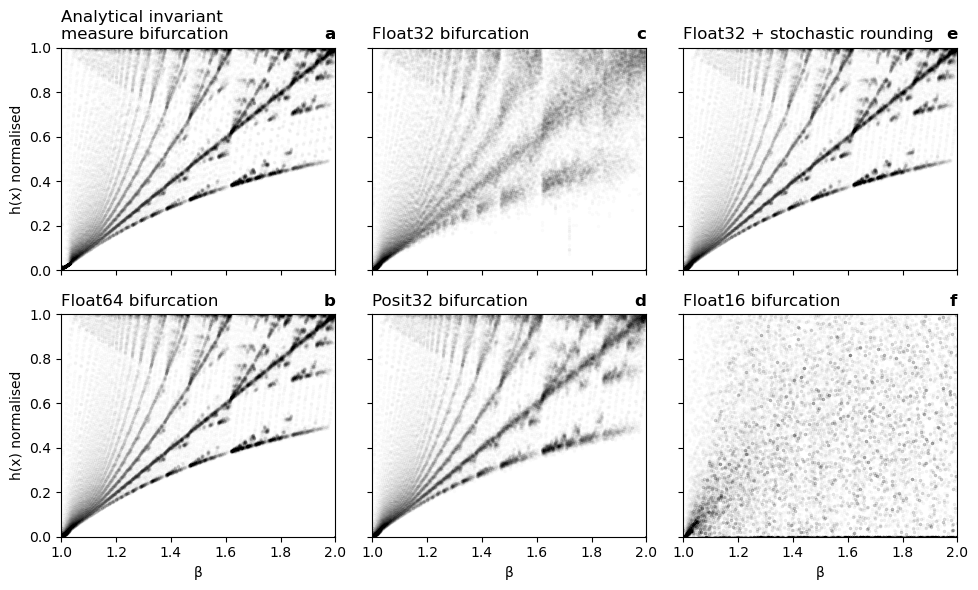

In [13]:
fig,axs = subplots(2,3,sharex=true,sharey=true,figsize=(10,6))

alfa = 0.01
axs[1,1].scatter(ββ,hxβn,3,color="k",alpha=alfa)
for i in 2:length(axs)
    axs[i].scatter(ββ,Histos2n[i-1,:,:],3,color="k",alpha=alfa)
end

axs[2,1].set_xlabel("β")
axs[2,2].set_xlabel("β")
axs[2,3].set_xlabel("β")
axs[1,1].set_ylabel("h(x) normalised")
axs[2,1].set_ylabel("h(x) normalised")
axs[1,1].set_xlim(extrema(βs2))
axs[1,1].set_ylim(0,1)

axs[1,1].set_title("Analytical invariant\nmeasure bifurcation",loc="left")
axs[1,1].set_title("a",loc="right",fontweight="bold")
for i in 2:length(axs)
    axs[i].set_title("$(string(formats[i-1])) bifurcation",loc="left")
    axs[i].set_title(string(Char(96+i)),loc="right",fontweight="bold")
end

axs[5].set_title("Float32 + stochastic rounding",loc="left")
    
tight_layout()
# savefig("../plots/bifurcation.png",dpi=200)

**Fig. 4** Bifurction diagram of the invariant measure $h(x)$ analytically and as simulated with various number formats. (a) Analytical invariant measure's bifurcation from Hofbauer's $h(x)$, (b-f) Bifurcation obtained from the histograms of $x$ simulated with various number formats: (b) Float64, (c) Float32, (d) Posit32, (e) Float32 + stochastic rounding, (f) Float16. Normlisation is applied with max($h_\beta(x)$).

### Wasserstein distance to assess histograms

In [14]:
using OptimalTransport, Distributions, Statistics

In [15]:
W = fill(0.0,Nformats,nβs)    # preallocate

for (iformat,format) in enumerate(formats)
    for (iβ,β) in enumerate(βs2)
        
        # set up distributions
        ν = DiscreteNonParametric(bin_mids,hxβ[:,iβ]/nbins)
        μ = DiscreteNonParametric(bin_mids,Histos2[iformat,iβ,:]/nbins)
        W[iformat,iβ] = wasserstein(ν,μ)
    end
end

In [16]:
# smoothing
βs3 = vcat(collect(1:2e-3:1.03),collect(1.05:5e-2:1.96),collect(1.98:5e-3:2))
Wsmooth = fill(0.0,Nformats,length(βs3))

for iβ in 1:length(βs3)-1
    iβ_idx = (βs2 .>= βs3[iβ]) .& (βs2 .< βs3[iβ+1]) 
    for iformat in 1:Nformats
        Wsmooth[iformat,iβ] = mean(W[iformat,iβ_idx])
    end
end

# copy over β=2
Wsmooth[:,end] = W[:,end];

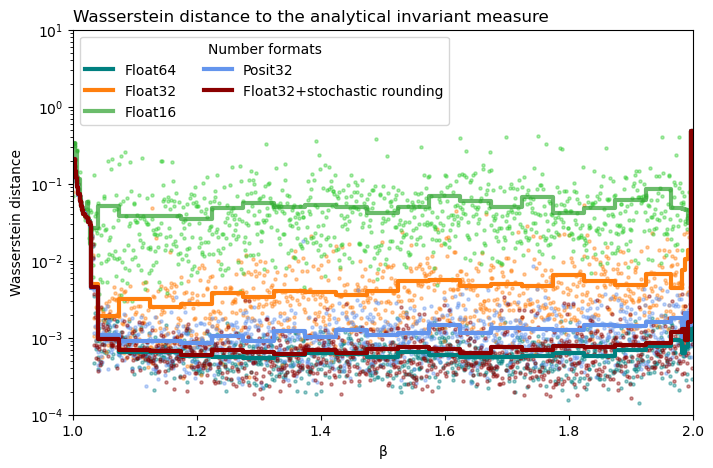

PyObject Text(0.0, 1.0, 'Wasserstein distance to the analytical invariant measure')

In [17]:
fig,ax1 = subplots(1,1,figsize=(8,5))
ax1.set_yscale("log")

alfa=0.4
ax1.scatter(βs2,W[1,:],5,c="teal",alpha=alfa)
ax1.scatter(βs2,W[2,:],5,c="C1",alpha=alfa)
ax1.scatter(βs2,W[5,:],5,c="limegreen",alpha=alfa)
ax1.scatter(βs2,W[3,:],5,c="cornflowerblue",alpha=alfa)
ax1.scatter(βs2,W[4,:],5,c="darkred",alpha=alfa)

lw = 3
ds="steps-mid"
ax1.plot(βs3,Wsmooth[1,:],"teal",label="Float64";lw,ds)
ax1.plot(βs3,Wsmooth[2,:],"C1",label="Float32";lw,ds)
ax1.plot(βs3,Wsmooth[5,:],"C2",alpha=.7,label="Float16";lw,ds)
ax1.plot(βs3,Wsmooth[3,:],"cornflowerblue",label="Posit32";lw,ds)
ax1.plot(βs3,Wsmooth[4,:],"darkred",label="Float32+stochastic rounding";lw,ds)


ax1.legend(loc=2,ncol=2,title="Number formats",scatterpoints=7)

ax1.set_xlim(extrema(βs2))
ax1.set_ylim(1e-4,10)
ax1.set_xlabel("β")
ax1.set_ylabel("Wasserstein distance")
ax1.set_title("Wasserstein distance to the analytical invariant measure",loc="left")

# savefig("../plots/wasserstein.png",dpi=200)